###Installtion and Setup

In [1]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-6nfeffg6
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-6nfeffg6
     |████████████████████████████████| 596 kB 8.7 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5-py3-none-any.whl size=65172 sha256=ab5eed479cb5c1aeee10158df383f455fc1c6e74735f5e1f5cd92ef32463c3c0
  Stored in directory: /tmp/pip-ephem-wheel-cache-3sbzd_a1/wheels/24/1d/09/8167de727fe5b74f832b6fcb5d9069d8f03ca29f337bfe484d
Successfully built fvcore
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


'1.11.0+cu113'

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MIT/3.\ Spring\ 2022/6.869/6.869\ Project/v-coco/
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Mounted at /content/drive
/content/drive/MyDrive/MIT/3. Spring 2022/6.869/6.869 Project/v-coco
fatal: destination path 'detectron2_repo' already exists and is not an empty directory.
Obtaining file:///content/drive/MyDrive/MIT/3.%20Spring%202022/6.869/6.869%20Project/v-coco/detectron2_repo
     |████████████████████████████████| 74 kB 3.0 MB/s 
     |████████████████████████████████| 147 kB 17.5 MB/s 
     |████████████████████████████████| 130 kB 78.4 MB/s 
     |████████████████████████████████| 38.1 MB 1.1 MB/s 
     |████████████████████████████████| 749 kB 69.9 MB/s 
     |████████████████████████████████| 843 kB 65.9 MB/s 
     |████████████████████████████████| 112 kB 79.2 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=ae8555fcda6f31c5bc0a43d3722c08e02ea5209f4c26f7a8e20ba4a2cbf3b603
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
Successfully buil

###Imports

In [1]:
# Some basic setup:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MIT/3.\ Spring\ 2022/6.869/6.869\ Project/v-coco/


import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from PIL import Image

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.visualizer import ColorMode

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MIT/3. Spring 2022/6.869/6.869 Project/v-coco


In [2]:
data_dir = "/content/drive/MyDrive/MIT/3. Spring 2022/6.869/6.869 Project/v-coco"
test_data_dir = "/content/drive/MyDrive/MIT/3. Spring 2022/6.869/6.869 Project/GroceryData"
model_dir = "/content/drive/MyDrive/MIT/3. Spring 2022/6.869/6.869 Project/v-coco/outputs"

In [3]:
from detectron2.data.datasets import register_coco_instances

global already_run 
already_run = False
def loadData():
  global already_run 
  if already_run: return

  options = {
      "action_obj": {"anno_path": "./data/instances_vcoco_agent_object_train.json", "image_path": "./coco/train2014"},
      "action_only": {"anno_path": "./data/instances_vcoco_actions_train.json", "image_path": "./coco/train2014"},
      "cutouts": {"anno_path": "./data/instances_vcoco_object_cutours_train.json", "image_path": "./coco/train2014_cutouts"},
      "grocery": {"anno_path": "../sandbox/grocerydata/d2s_annotations_v1.1/annotations/D2S_validation.json", "image_path": "../sandbox/grocerydata/images"},
  }

  for key in options.keys():
    option = options[key]
    register_coco_instances(key, {}, option["anno_path"], option["image_path"])
  already_run = True

loadData()

def getMetaData(key):
  train_metadata = MetadataCatalog.get(key)
  train_dicts = DatasetCatalog.get(key)
  return (train_metadata, train_dicts)

In [ ]:
import random
train_metadata, train_dicts = getMetaData("grocery")
for d in random.sample(train_dicts, 3):
    print(d)
    #Note, due to how much data is in this directory on the drive, Google Drive timesout several times when running the line below.
    #This line will work if you run it 4-5x once Google cches the entire directory
    img = cv2.imread(d["file_name"]) #Start at 7 due to script name mismatch
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

### Utilities

In [133]:
def run_inference(predictor, im_path):
  im = cv2.imread(im_path)
  outputs = predictor(im)
  x = outputs["instances"].to("cpu")
  return x


def visualize(outputs, key="empty", visualize=True):
  if key == "empty": raise "You need a key"
  # print(MetadataCatalog.get(key))
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(key), scale=1.2)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  if visualize: cv2_imshow(out.get_image()[:, :, ::-1])
  return out.get_image()[:, :, ::-1]


def cutout_box(im, boxes, display=False, baseImage=False):
  """Removes all pixels but objects
  """
  background = Image.new('RGB', (im.shape[1], im.shape[0]), (0, 0, 0))
  new_fg_image = Image.new('RGB', background.size)
  if type(baseImage) != bool: new_fg_image = Image.fromarray(baseImage)
  for box in boxes:
    segmentation = box
    x_min = int(segmentation[0])
    y_min = int(segmentation[1])
    x_max = int(x_min + segmentation[2])
    y_max = int(y_min + segmentation[3])
    # print(x_min, x_max, y_min, y_max)

    cropped = Image.fromarray(im[y_min:y_max, x_min:x_max, :], mode='RGB')
    paste_position = (x_min, y_min)
    new_fg_image.paste(cropped, paste_position)

  if display: cv2_imshow(np.array(new_fg_image))

  return new_fg_image

def crop_object_from_pred_boxes(image_path, box, baseImage=False):
  """Crops an object out of an image
  """
  image = Image.open(image_path)
  if type(baseImage) != bool: image = Image.fromarray(baseImage)
  x_top_left = box[0]
  y_top_left = box[1]
  x_bottom_right = box[2]
  y_bottom_right = box[3]
  x_center = (x_top_left + x_bottom_right) / 2
  y_center = (y_top_left + y_bottom_right) / 2

  crop_img = image.crop((int(x_top_left), int(y_top_left), int(x_bottom_right), int(y_bottom_right)))
  return crop_img

def get_people(outputs, person_id=0):
  classes = outputs.pred_classes.detach().cpu().numpy()
  people_ids = [idx for idx, tag in enumerate(classes) if idx == person_id]
  people = []
  for p_idx in people_ids:
    person = {
      "box": outputs.pred_boxes[p_idx].tensor.cpu().numpy()[0],
      "score": outputs.scores[p_idx],
      "class": outputs.pred_classes[p_idx],
    }
    people.append(person)

  return people

def get_objects(outputs, person_id=0):
  classes = outputs.pred_classes.detach().cpu().numpy()
  object_ids = [idx for idx, tag in enumerate(classes) if idx != person_id]
  objects = []
  for o_idx in object_ids:
    object_ = {
      "box": outputs.pred_boxes[o_idx].tensor.cpu().numpy()[0],
      "score": outputs.scores[o_idx],
      "class": outputs.pred_classes[o_idx],
    }
    objects.append(object_)

  return objects

def get_person_obj_pairs(outputs, person_id=0):
  classes = outputs.pred_classes.detach().cpu().numpy()
  people_ids = [idx for idx, tag in enumerate(classes) if idx == person_id]
  obj_ids = [idx for idx, tag in enumerate(classes) if idx != person_id]

  pairs = []
  for p_idx in people_ids:
    person = {
        "box": outputs.pred_boxes[p_idx].tensor.cpu().numpy()[0],
        "score": outputs.scores[p_idx],
        "class": outputs.pred_classes[p_idx],
    }
    for o_idx in obj_ids:
      obj = {
          "box": outputs.pred_boxes[o_idx].tensor.cpu().numpy()[0], 
          "score": outputs.scores[o_idx], 
          "class": outputs.pred_classes[o_idx],
      }
      pair = (person, obj)
      pairs.append(pair)

  return pairs

def get_test_images():
  # 'image06.png','image09.png' 'image11.png'
  paths = image_list = ['image02.jpeg', 'image01.jpeg', 'image03.jpeg', 'image04.jpeg', 'image05.jpeg',  'image07.jpeg', 'image08.jpeg', 'image10.jpeg', 'image12.jpeg', 'image13.jpeg', 'image14.jpeg', 'image36.jpeg', 'image37.jpeg', 'image38.jpeg', 'image39.jpeg', 'image40.jpeg', 'image41.jpeg', 'image42.jpeg', 'image43.jpeg', 'image44.jpeg', 'image45.jpeg', 'image46.jpeg', 'image47.jpeg', 'image48.jpeg', 'image49.jpeg', 'image50.jpeg']
  paths = [ "../GroceryImages/"+img for img in paths]
  return paths

def get_best_action(outputs):
  scores = outputs["instances"].scores.cpu().numpy()
  classes = outputs["instances"].pred_classes.cpu().numpy()
  max_index = np.argmax(scores)
  max_class = classes[max_index]
  meta = MetadataCatalog.get("action_only")
  action = meta.thing_classes[max_class]
  return action

def get_best_target(outputs):
  scores = outputs["instances"].scores.cpu().numpy()
  classes = outputs["instances"].pred_classes.cpu().numpy()
  max_index = np.argmax(scores)
  target = outputs["instances"].__getitem__(0)
  target_obj = {
      "box": target.get("pred_boxes")[0], 
      "score": target.get("scores")[0], 
      "class": target.get("pred_classes")[0],
  }
  return target, target_obj

### Model Loading

#### Branch A

In [7]:
#BRANCH A
# Get the default config and set for pre-made RCNN Object Detector
cfg_branch_A = get_cfg()
cfg_branch_A.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_branch_A.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg_branch_A.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75  # set threshold for this model
branch_A = DefaultPredictor(cfg_branch_A)


####Branch B

In [32]:
#BRANCH B
#Classifies actions of people
cfg_branch_B = get_cfg()
# cfg_branch_B.merge_from_file("./detectron2_repo/configs/COCO-Detection/retinanet_R_50_FPN_3x.yaml")
# cfg_branch_B.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml") 
cfg_branch_B.merge_from_file("./detectron2_repo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg_branch_B.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml") 
cfg_branch_B.DATALOADER.NUM_WORKERS = 2
cfg_branch_B.SOLVER.IMS_PER_BATCH = 2
cfg_branch_B.SOLVER.BASE_LR = 0.002
cfg_branch_B.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough, but you can certainly train longer
cfg_branch_B.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset
cfg_branch_B.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg_branch_B.DATASETS.TRAIN = ("action_only",)
cfg_branch_B.DATASETS.TEST = ()
cfg_branch_B.MODEL.ROI_HEADS.NUM_CLASSES = 7  # all relevant classes
cfg_branch_B.MODEL.RETINANET.NUM_CLASSES = 7
cfg_branch_B.OUTPUT_DIR = "./outputs/action_only_detector"

branch_B_trainer = DefaultTrainer(cfg_branch_B)
branch_B_trainer.resume_or_load(resume=False)
branch_B_trainer.train()
cfg_branch_B.MODEL.WEIGHTS = os.path.join(cfg_branch_B.OUTPUT_DIR, "model_final.pth")
branch_B = DefaultPredictor(cfg_branch_B)

[05/10 14:01:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (28, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (28,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[05/10 14:01:11 d2.engine.train_loop]: Starting training from iteration 0
[05/10 14:01:16 d2.utils.events]:  eta: 0:04:02  iter: 19  total_loss: 2.327  loss_cls: 2.039  loss_box_reg: 0.2701  loss_rpn_cls: 0.01587  loss_rpn_loc: 0.004928  time: 0.2522  data_time: 0.0184  lr: 3.9962e-05  max_mem: 4350M
[05/10 14:01:22 d2.utils.events]:  eta: 0:04:02  iter: 39  total_loss: 1.73  loss_cls: 1.317  loss_box_reg: 0.3146  loss_rpn_cls: 0.02924  loss_rpn_loc: 0.00423  time: 0.2604  data_time: 0.0134  lr: 7.9922e-05  max_mem: 4350M
[05/10 14:01:27 d2.utils.events]:  eta: 0:03:59  iter: 59  total_loss: 0.8671  loss_cls: 0.4781  loss_box_reg: 0.3069  loss_rpn_cls: 0.01733  loss_rpn_loc: 0.005407  time: 0.2611  data_time: 0.0107  lr: 0.00011988  max_mem: 4350M
[05/10 14:01:33 d2.utils.events]:  eta: 0:03:54  iter: 79  total_loss: 0.7193  loss_cls: 0.3559  loss_box_reg: 0.3516  loss_rpn_cls: 0.01756  loss_rpn_loc: 0.004223  time: 0.2601  data_time: 0.0095  lr: 0.00015984  max_mem: 4350M
[05/10 14:01

####Branch C

In [29]:
#BRANCH C
#Finds object targets for given person/action pairs
cfg_branch_C = get_cfg()
cfg_branch_C.merge_from_file("./detectron2_repo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg_branch_C.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml") 
cfg_branch_C.DATALOADER.NUM_WORKERS = 2
cfg_branch_C.SOLVER.IMS_PER_BATCH = 2
cfg_branch_C.SOLVER.BASE_LR = 0.002
cfg_branch_C.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough, but you can certainly train longer
cfg_branch_C.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset
cfg_branch_C.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75   # set the testing threshold for this model
cfg_branch_C.DATASETS.TRAIN = ("cutouts",)
cfg_branch_C.DATASETS.TEST = ()
cfg_branch_C.MODEL.ROI_HEADS.NUM_CLASSES = 5  # all relevant classes
cfg_branch_C.MODEL.RETINANET.NUM_CLASSES = 5
cfg_branch_C.OUTPUT_DIR = "./outputs/action_object_localizer2"

branch_C_trainer = DefaultTrainer(cfg_branch_C)
branch_C_trainer.resume_or_load(resume=False)
branch_C_trainer.train()
cfg_branch_C.MODEL.WEIGHTS = os.path.join(cfg_branch_C.OUTPUT_DIR, "model_final.pth")
branch_C = DefaultPredictor(cfg_branch_C)

[05/10 13:55:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[05/10 13:55:44 d2.engine.train_loop]: Starting training from iteration 0
[05/10 13:55:50 d2.utils.events]:  eta: 0:04:23  iter: 19  total_loss: 2  loss_cls: 1.734  loss_box_reg: 0.2608  loss_rpn_cls: 0.01378  loss_rpn_loc: 0.007304  time: 0.2660  data_time: 0.0165  lr: 3.9962e-05  max_mem: 4348M
[05/10 13:55:55 d2.utils.events]:  eta: 0:04:05  iter: 39  total_loss: 1.338  loss_cls: 0.9757  loss_box_reg: 0.3267  loss_rpn_cls: 0.0115  loss_rpn_loc: 0.004659  time: 0.2599  data_time: 0.0096  lr: 7.9922e-05  max_mem: 4348M
[05/10 13:56:01 d2.utils.events]:  eta: 0:04:00  iter: 59  total_loss: 0.7078  loss_cls: 0.4134  loss_box_reg: 0.2966  loss_rpn_cls: 0.006501  loss_rpn_loc: 0.006218  time: 0.2594  data_time: 0.0117  lr: 0.00011988  max_mem: 4348M
[05/10 13:56:06 d2.utils.events]:  eta: 0:03:51  iter: 79  total_loss: 0.5521  loss_cls: 0.2667  loss_box_reg: 0.2762  loss_rpn_cls: 0.005368  loss_rpn_loc: 0.005514  time: 0.2569  data_time: 0.0109  lr: 0.00015984  max_mem: 4348M
[05/10 13:56

####Branch D

In [37]:
#BRANCH D
#Finds object targets for given person/action pairs
cfg_branch_D = get_cfg()
cfg_branch_D.merge_from_file("./detectron2_repo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg_branch_D.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml") 
cfg_branch_D.DATALOADER.NUM_WORKERS = 2
cfg_branch_D.SOLVER.IMS_PER_BATCH = 2
cfg_branch_D.SOLVER.BASE_LR = 0.002
cfg_branch_D.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough, but you can certainly train longer
cfg_branch_D.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset
cfg_branch_D.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.15   # set the testing threshold for this model
cfg_branch_D.DATASETS.TRAIN = ("grocery",)
cfg_branch_D.DATASETS.TEST = ()
cfg_branch_D.MODEL.ROI_HEADS.NUM_CLASSES = 60  # all relevant classes
cfg_branch_D.MODEL.RETINANET.NUM_CLASSES = 60
cfg_branch_D.OUTPUT_DIR = "./outputs/grocery_detector"

branch_D_trainer = DefaultTrainer(cfg_branch_D)
branch_D_trainer.resume_or_load(resume=False)
branch_D_trainer.train()
cfg_branch_D.MODEL.WEIGHTS = os.path.join(cfg_branch_D.OUTPUT_DIR, "model_final.pth")
branch_D = DefaultPredictor(cfg_branch_D)

[05/10 14:34:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (61, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (61,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (240, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (240,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bi

[05/10 14:34:24 d2.engine.train_loop]: Starting training from iteration 0
[05/10 14:34:30 d2.utils.events]:  eta: 0:04:39  iter: 19  total_loss: 4.753  loss_cls: 4.053  loss_box_reg: 0.7125  loss_rpn_cls: 0.008402  loss_rpn_loc: 0.01374  time: 0.2826  data_time: 0.0357  lr: 3.9962e-05  max_mem: 4350M
[05/10 14:34:36 d2.utils.events]:  eta: 0:04:33  iter: 39  total_loss: 3.81  loss_cls: 2.996  loss_box_reg: 0.7764  loss_rpn_cls: 0.01286  loss_rpn_loc: 0.01298  time: 0.2883  data_time: 0.0400  lr: 7.9922e-05  max_mem: 4350M
[05/10 14:34:41 d2.utils.events]:  eta: 0:04:24  iter: 59  total_loss: 2.022  loss_cls: 1.203  loss_box_reg: 0.7212  loss_rpn_cls: 0.01384  loss_rpn_loc: 0.008133  time: 0.2861  data_time: 0.0209  lr: 0.00011988  max_mem: 4350M
[05/10 14:34:47 d2.utils.events]:  eta: 0:04:19  iter: 79  total_loss: 1.923  loss_cls: 1.111  loss_box_reg: 0.8067  loss_rpn_cls: 0.005894  loss_rpn_loc: 0.01074  time: 0.2859  data_time: 0.0200  lr: 0.00015984  max_mem: 4350M
[05/10 14:34:52 

####Visualiztion Tester

[05/10 14:00:21 d2.data.datasets.coco]: Loaded 1489 images in COCO format from ./data/instances_vcoco_object_cutours_train.json
tensor([0])


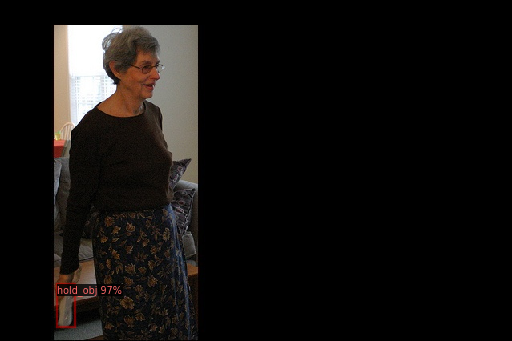

tensor([0])


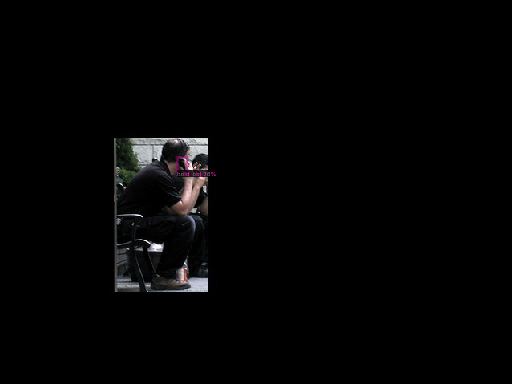

tensor([0])


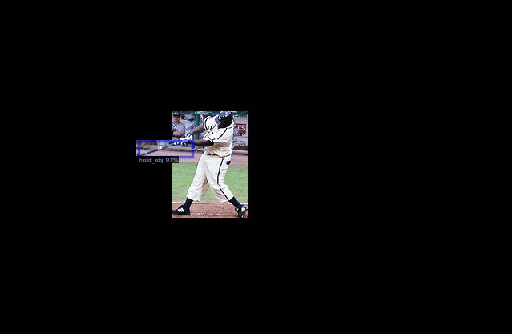

In [31]:
from detectron2.utils.visualizer import ColorMode
train_metadata, train_dicts = getMetaData("cutouts")
for d in random.sample(train_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = branch_C(im)
    x = outputs["instances"].to("cpu")
    print(x.pred_classes)
    v = Visualizer(im[:, :, ::-1],
                   metadata=train_metadata, 
                   scale=0.8, 
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

### Execution Pipeline

In [134]:
image_paths = get_test_images()

for i, path in enumerate(image_paths):
  #load image for inference
  im = cv2.imread(path)

  #get all objects found in image
  obj_outputs = branch_A(im)
  visualize(obj_outputs, cfg_branch_A.DATASETS.TRAIN[0], visualize=False)

  #Get all person and personobject pairs
  pers = get_people(obj_outputs["instances"])
  objs = get_objects(obj_outputs["instances"])
  per_obj_pairs = get_person_obj_pairs(obj_outputs["instances"])

  #classify actions of people
  actions = []
  action_ims = []
  targets = []
  target_ims = []
  objs = []
  for person in pers:
    box = person["box"]
    per_crop = crop_object_from_pred_boxes(path, box)
    per_crop = np.array(per_crop) 
    act_ouputs = branch_B(per_crop)
    action_im = visualize(target_outputs, "action_only", visualize=False)
    action_ims.append(action_im)
    best_action = get_best_action(act_ouputs)
    actions.append(best_action)
  
    #classify all targets of people's actions
    last_target_score = 0
    for obj in objs:
      boxes = (person["box"], obj["box"])
      cutout_img = cutout_box(im, boxes)
      target_outputs = branch_C(np.array(cutout_img))
      instances, target = get_best_target(target_outputs)
      target_outputs = {"instances": instances}
      visualize(target_outputs, "cutouts", visualize=False)

      if float(target["score"]) > last_target_score:
        final_target = target
        final_target_output = target_outputs
        last_target_score = float(target["score"])
    
    target_im = visualize(final_target_output, "cutouts", visualize=False)
    target_ims.append(target_im)
    targets.append(final_target)

    obj_outputs = branch_D(np.array(target_im))
    instances, obj = get_best_target(obj_outputs)
    md, td = getMetaData("grocery")
    obj_class = md.thing_classes[obj["class"]]
    objs.append(obj_class)

    cv2_imshow(per_crop[:, :, ::-1])
    print(best_action,obj_class)


  # out.save(f"../sandbox/annotated_shopping/final_pipeline_results/{i}.jpeg")


Output hidden; open in https://colab.research.google.com to view.